# ``Taming Performance Variability''

### <font color='red'> Notebook for Quantile Regression analysis for both disk and memory data</font>

In [1]:
import os, sys
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
#import seaborn.apionly as sns
import seaborn as sns
import matplotlib.dates as md
from matplotlib import gridspec
import matplotlib.patches as patches
import datetime as dt
from collections import OrderedDict 
from collections import deque
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import warnings
from scipy.stats import norm
from IPython.display import IFrame
from IPython.display import Markdown, display
from IPython.display import FileLink, FileLinks

warnings.filterwarnings(action='once')

# With plot_show_and_save() defined below, there is no need for this configuration
# (all plots should use plot_show_and_save())
#%matplotlib inline

# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Read all inputs from this directory
source_dir = "../data/raw-data/"
# Save all dataframes and plots into this directory 
dest_dir = "output/"

if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)

# db -- dictinary with keys - table names, values - dataframes with table data
db = {}

for f in os.listdir(source_dir):
    if ".csv" in f:
        db[os.path.splitext(f)[0]] = pd.read_csv(source_dir + f)
    
# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# If vebose is set, additional debug info will be printed throughout the notebook
verbose = True
if verbose:
    print "Keys: ", db.keys()
    for k, df in db.iteritems():
        #print "Sample from %s:" % k 
        #print df.head(3), "\n\n" 
        print "Columns in %s:" % k, df.columns 

####  Define default graphics parameters ###

####  Include common helper functions

sys.path.append("bench-lib/")
from common import *

/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Keys:  ['disk_info', 'iperf3_info', 'iperf3_results', 'ping_results', 'env_info', 'membench_info', 'disk_results', 'fio_info', 'stream_info', 'network_info', 'mem_results', 'ping_info']
Columns in disk_info: Index([u'run_uuid', u'timestamp', u'nodeid', u'nodeuuid', u'disk_name',
       u'disk_model', u'disk_serial', u'disk_size', u'npartitions',
       u'disk_type'],
      dtype='object')
Columns in iperf3_info: Index([u'run_uuid', u'timestamp', u'nodeid', u'nodeuuid', u'version',
       u'local_ip', u'local_port', u'remote_ip', u'remote_port',
       u'remote_nodeid', u'protocol', u'num_streams', u'buffer_size',
       u'omitted_intervals', u'duration', u'time_units'],
      dtype='object')
Columns in iperf3_results: Index([u'run_uuid', u'timestamp', u'nodeid', u'nodeuuid', u'reverse',
       u'retransmits', u'local_cpu_util', u'remote_cpu_util', u'median',
       u'max', u'min', u'mean', u'stdev', u'sum_sent', u'sum_received',
       u'units'],
      dtype='object')
Columns in ping_r

In [2]:
# Combine disk_results and env_info

disk_all = pd.merge(db['disk_results'], db["env_info"], on=["run_uuid", "nodeid", "nodeuuid", "timestamp"])

# Infer disk_name from device (/dev/sda4 -> /dev/sda)
disk_all["disk_name"] = disk_all["device"].apply(lambda x: x.rstrip(string.digits))

# Add disk info
disk_all = pd.merge(disk_all, db['disk_info'], 
                               on=["run_uuid", "timestamp", "nodeuuid", "disk_name"])  

# df2csv(disk_all, "disk_all.csv", dest_dir)

#disk_full[disk_full["site"] == "clemson"]["nthreads"].value_counts()
disk_all.sample(20).T 

15716   \
run_uuid             0411a485-fc84-40a9-95b6-3ac3b7be9241   
timestamp                                      1497984378   
nodeid_x                                        clnode157   
nodeuuid             d3b5fcae-fee3-11e5-ba07-000099989701   
testname                                        randwrite   
runtime                                           720.304   
size                                          1.30034e+06   
max                                                  2169   
min                                                     0   
mean                                              1805.78   
stdev                                             115.519   
units                                                KB/s   
device                                          /dev/sda4   
iodepth                                              4096   
gcc_ver                                             5.4.0   
version_hash     619f70a1190c46eff9e5beb7643f4059370f82ed   
total_mem                                          256GiB   
mem_clock_speed                                   2133MHz   
arch                                               x86_64   
run_success                                             1   
site                                              clemson   
nthreads                                               56   
nsockets                                                2   
hw_type                                             c6320   
disk_name                                        /dev/sda   
nodeid_y                                        clnode157   
disk_model                                   ST91000640NS   
disk_serial                                      9XG9L0VB   
disk_size                                          931.5G   
npartitions                                             4   
disk_type                                             HDD   

                                                   111519  \
run_uuid             50b6ceac-a60f-42d1-8a00-4b2b7d445de8   
timestamp                                      1519996307   
nodeid_x                                           ms0314   
nodeuuid             312e2adb-72db-11e4-85c8-179a28bd1b8c   
testname                                            write   
runtime                                            87.882   
size                                          1.04858e+07   
max                                                122910   
min                                                 88066   
mean                                               119244   
stdev                                             2866.65   
units                                                KB/s   
device                                          /dev/sda2   
iodepth                                              4096   
gcc_ver                                             5.4.0   
version_hash     9e67da94c8dc1846d9131ca4dbd0d6c5fb41307d   
total_mem                                           62GiB   
mem_clock_speed                              Unknown(ARM)   
arch                                              aarch64   
run_success                                             1   
site                                                 utah   
nthreads                                                8   
nsockets                                                1   
hw_type                                              m400   
disk_name                                        /dev/sda   
nodeid_y                                           ms0314   
disk_model                                    XR0120GEBLT   
disk_serial                                  14340D3B760E   
disk_size                                          111.8G   
npartitions                                             3   
disk_type                                             SSD   

                                                   78818   \
run_uuid             bae672e1-c5a9-4918-99b7-7b5a8424dce3   
timestamp              

In [3]:
# Combine mem_results and env_info

mem_all = pd.merge(db['mem_results'], db["env_info"], on=["run_uuid", "nodeid", "nodeuuid", "timestamp"])
df2csv(mem_all, "mem_all.csv", dest_dir)

mem_all.sample(20).T 

140589  \
run_uuid             d1c91682-a5f0-4a07-97df-136d0003191b   
timestamp                                      1499669177   
nodeid                                          clnode027   
nodeuuid             cfc58d68-d7f1-11e4-b34b-000099989701   
nthreads_used                                          10   
testname                          write_memory_memset_omp   
max                                               17999.6   
min                                               17900.1   
mean                                              17927.8   
stdev                                                36.6   
units                                                MB/s   
socket_num                                              1   
dvfs                                                   no   
gcc_ver                                             5.4.0   
version_hash     6e2eedd0f3c165252682c45e34764016278edd06   
total_mem                                          256GiB   
mem_clock_speed                                   1333MHz   
arch                                               x86_64   
run_success                                             1   
site                                              clemson   
nthreads                                               20   
nsockets                                                2   
hw_type                                             c8220   

                                                   114648  \
run_uuid             8747a71f-6e21-40fb-aad1-d5e847537f28   
timestamp                                      1499129196   
nodeid                                          clnode116   
nodeuuid             63911c04-fee2-11e5-ba07-000099989701   
nthreads_used                                          28   
testname                       write_memory_rep_stosq_omp   
max                                               39732.8   
min                                               39477.9   
mean                                              39664.4   
stdev                                                  94   
units                                                MB/s   
socket_num                                              1   
dvfs                                                  yes   
gcc_ver                                             5.4.0   
version_hash     6e2eedd0f3c165252682c45e34764016278edd06   
total_mem                                          256GiB   
mem_clock_speed                                   2133MHz   
arch                                               x86_64   
run_success                                             1   
site                                              clemson   
nthreads                                               56   
nsockets                                                2   
hw_type                                             c6320   

                                                   27711   \
run_uuid             5f20a69c-2c84-4c3a-83a8-0623d2ad258c   
timestamp                                      1496688377   
nodeid                                          clnode099   
nodeuuid             6c29dc56-fee1-11e5-ba07-000099989701   
nthreads_used                                           1   
testname                                  read_memory_avx   
max                                               10843.1   
min                                               10830.3   
mean                                              10838.2   
stdev                                                 4.7   
units                                                MB/s   
socket_num                                              0   
dvfs                                                  yes   
gcc_ver                                             5.4.0   
version_hash     ffa0b0cc7d010c36e7b154dfdb484dc476d9308a   
total_mem                                          256GiB   
mem_clock_speed                                   2133MHz   
arch                   

In [4]:
# This Quantile Regression analysis is inspired by: https://dl.acm.org/citation.cfm?id=2451140

def qr_fit_model(qr, factor, q):
    res = qr.fit(q=q)
    res_df = pd.DataFrame([{"q": q}]) 
    for p in res.params.index.values:
        res_df[p] = res.params[p]
        res_df[str(p) + "_lb"] = res.conf_int().loc[p, 0]
        res_df[str(p) + "_ub"] = res.conf_int().loc[p, 1]
    return res_df

def qr_factor_analysis(name, df, metric, factor, quantiles=np.arange(.05, .96, .05), verbose=True):

    if verbose:
        print "Number of samples: ", len(df)
        
    qr = smf.quantreg('%s ~ %s' % (metric, factor), df)
    qr_models = pd.DataFrame()
    for q in quantiles:
        qr_models = qr_models.append(qr_fit_model(qr, factor, q), ignore_index=True)
    
    if verbose:    
        print qr_models
    
    vars = list(set([c.replace("_lb", "").replace("_ub", "") for c in qr_models.columns if c != "q"]))
    
    # Rearrange such that "Intercept" goes first
    vars = ["Intercept"] + [v for v in vars if v != "Intercept"]
    
    color_map = get_cmap_from_list(vars)
    
    # Find proper label for Intercept
    intercept_label = "Intercept"
    if factor in df.columns.tolist():
        used_types = set([v.split(".")[1].rstrip("]") for v in vars if v != "Intercept"])
        all_types = set(df[factor].unique())
        intercept_candidates = list(all_types - used_types)
        if len(intercept_candidates) > 1:
            print "Error: multiple candidate labels are found for Intercept"
        intercept_label = "Base Case: %s" % intercept_candidates[0] 
    
    fig, ax = plt.subplots(figsize=(8.5, 4))
    
    for v in vars:
        ax.plot(qr_models.q, qr_models[v], color=color_map[v], label=v if v != "Intercept" else intercept_label,
               lw=3.0 if v == "Intercept" else 1.0)
        ax.plot(qr_models.q, qr_models[str(v)+"_lb"], linestyle='dotted', color=color_map[v], label='_nolegend_')
        ax.plot(qr_models.q, qr_models[str(v)+"_ub"], linestyle='dotted', color=color_map[v], label='_nolegend_')
        #ax.set_title(name + ", " + v)   
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plot_show_and_save(fig, "qr-%s-%s.pdf" % (name, factor), dest_dir)

/opt/conda/envs/py27/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)


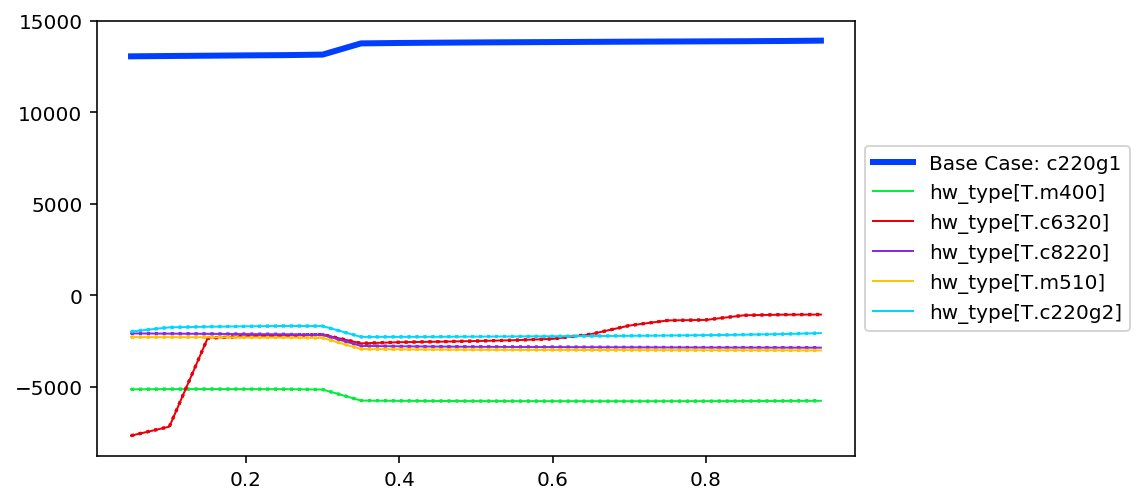

/notebooks/output/qr-ST-hw_type.pdf

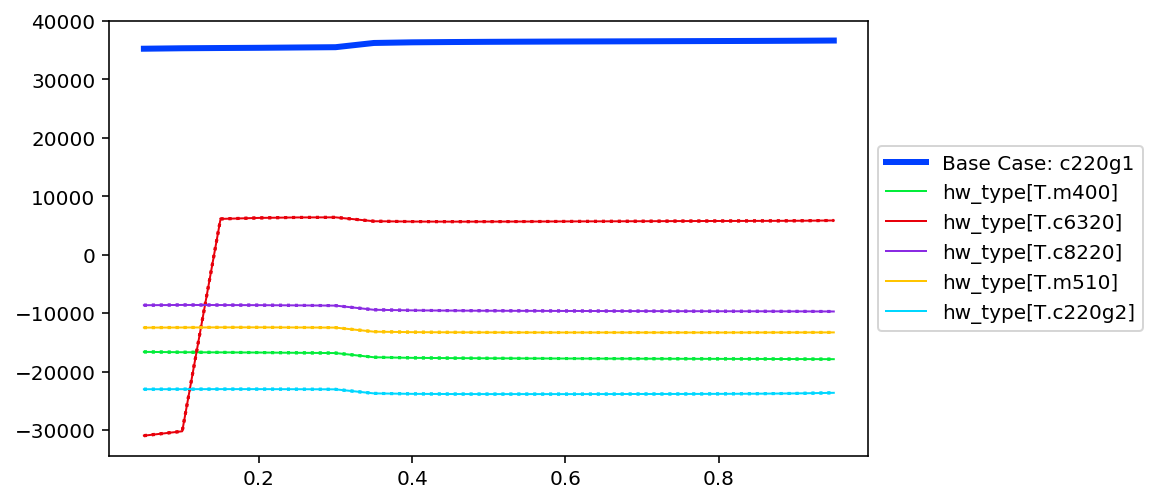

/notebooks/output/qr-MT-hw_type.pdf

In [5]:
m_st = subset_df(mem_all, {"testname": "add", "dvfs": "yes", "socket_num": 0})
m_mt = subset_df(mem_all, {"testname": "add_omp", "dvfs": "yes", "socket_num": 0})    
    
qr_factor_analysis("ST", m_st, "mean", "hw_type", verbose=False)
qr_factor_analysis("MT", m_mt, "mean", "hw_type", verbose=False)

Starting # of samples:  141408
Selecting based on nodeid=c220g2-011308. # of samples: 1920
Selecting based on device=/dev/sda4. # of samples: 640
Selecting based on testname=read. # of samples: 160
Selecting based on iodepth=4096. # of samples: 80
Starting # of samples:  141408
Selecting based on nodeid=c220g2-010823. # of samples: 1200
Selecting based on device=/dev/sda4. # of samples: 400
Selecting based on testname=read. # of samples: 100
Selecting based on iodepth=4096. # of samples: 50


/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/regression/quantile_regression.py:237: RuntimeWarning: invalid value encountered in less_equal
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)
/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


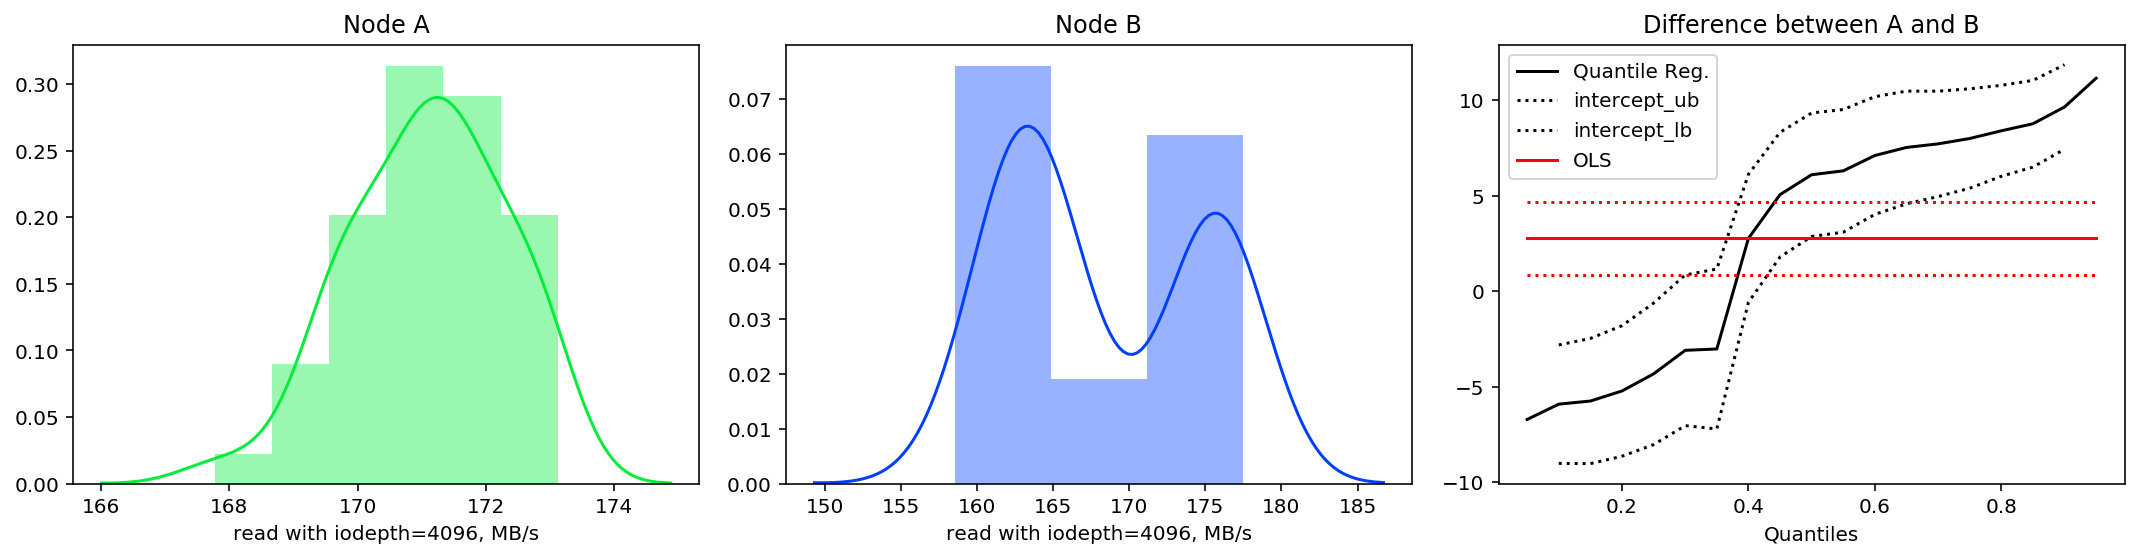

Starting # of samples:  141408
Selecting based on nodeid=c220g2-011308. # of samples: 1920
Selecting based on device=/dev/sda4. # of samples: 640
Selecting based on testname=read. # of samples: 160
Selecting based on iodepth=4096. # of samples: 80
Starting # of samples:  141408
Selecting based on nodeid=c220g2-011323. # of samples: 1800
Selecting based on device=/dev/sda4. # of samples: 600
Selecting based on testname=read. # of samples: 150
Selecting based on iodepth=4096. # of samples: 75


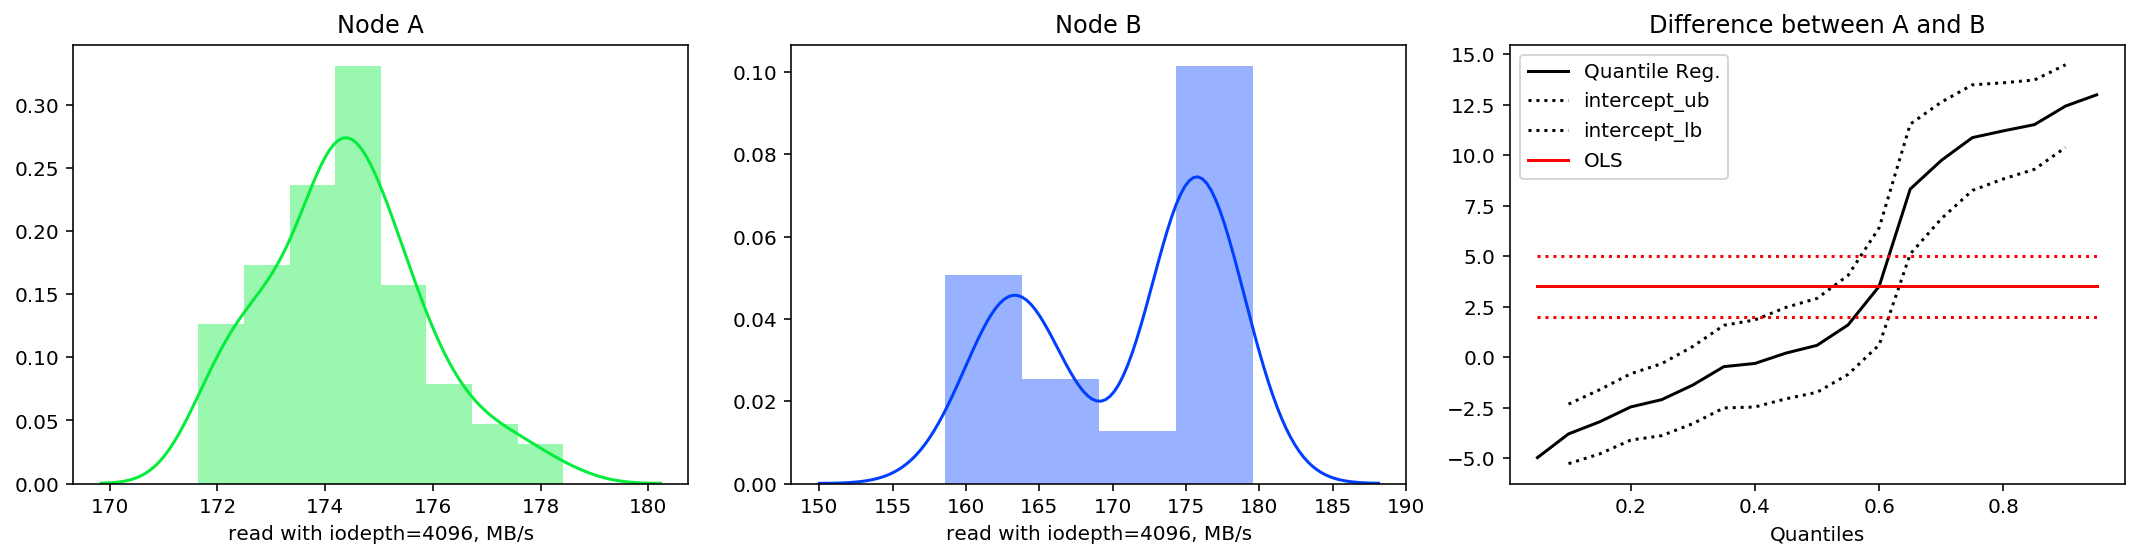

Starting # of samples:  141408
Selecting based on nodeid=c220g2-011308. # of samples: 1920
Selecting based on device=/dev/sdc. # of samples: 640
Selecting based on testname=randread. # of samples: 160
Selecting based on iodepth=1. # of samples: 80
Starting # of samples:  141408
Selecting based on nodeid=c220g2-010823. # of samples: 1200
Selecting based on device=/dev/sdc. # of samples: 400
Selecting based on testname=randread. # of samples: 100
Selecting based on iodepth=1. # of samples: 50


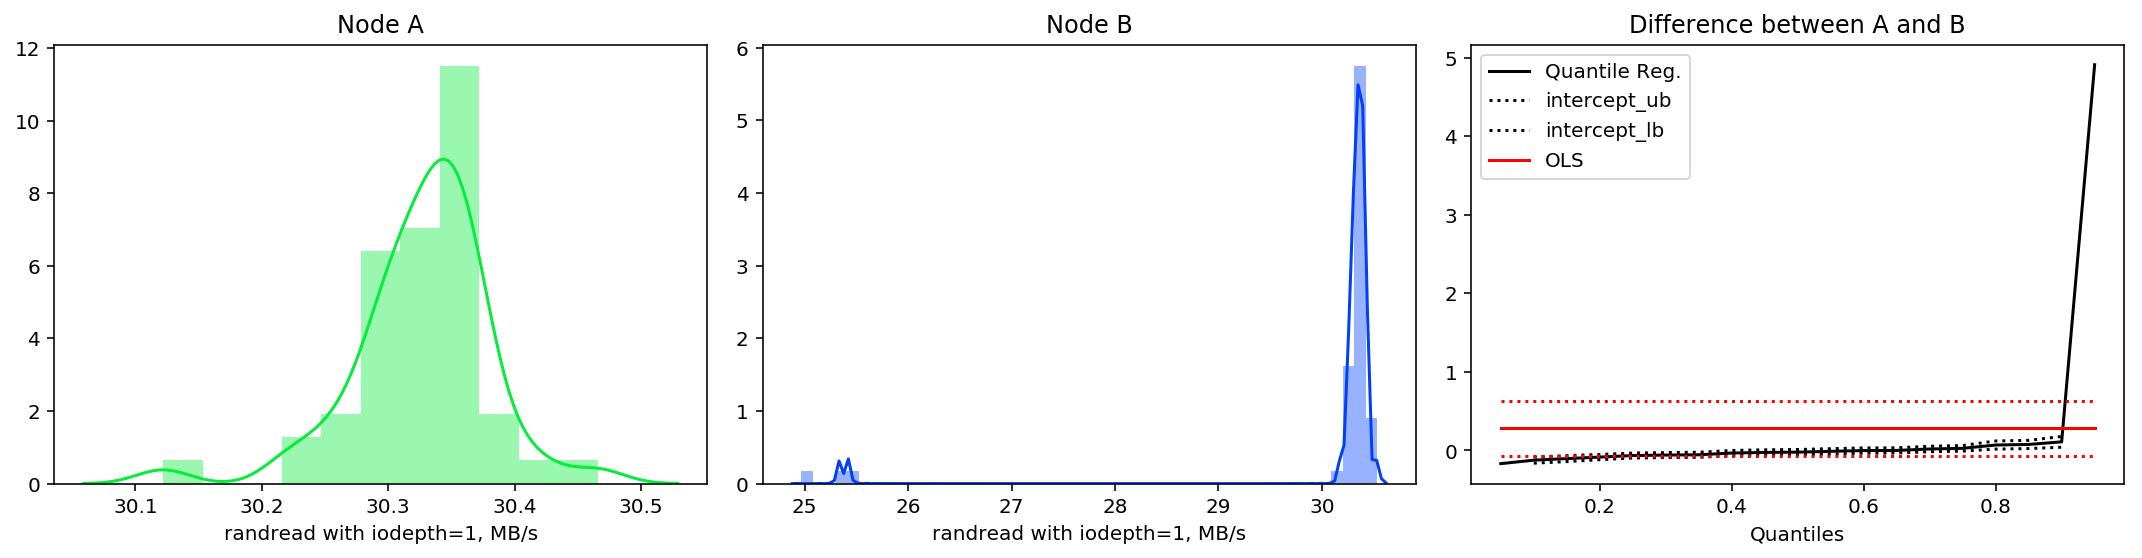

In [6]:
# Compare two specific nodes using quantile regression

# This system-to-system comparison is insipred by: 
# https://htor.inf.ethz.ch/publications/img/hoefler-scientific-benchmarking.pdf

quantiles = np.arange(.05, .96, .05)

def qr_fit_model(qr, q):
    res = qr.fit(q=q)
    return [q, res.params['Intercept'], res.params['zero']] + res.conf_int().loc['Intercept'].tolist()

def qr_compare(pair, metric):
    # Color-coding based on nodeid
    color_labels = [el["nodeid"] for el in pair]
    rgb_values = sns.color_palette("bright", len(pair))
    color_map = dict(zip(color_labels, rgb_values))
    
    df = pd.DataFrame()
    for p in pair:
        subset = db['disk_results']
        print "Starting # of samples: ", len(subset)
        label = ""
        for k,v in p.iteritems():
            subset = subset[subset[k] == v]
            label += str(v) + ", "
            print "Selecting based on %s=%s. # of samples: %d" % (k, v, len(subset))
        
        # Handle vectors of different lengths
        if len(df) == 0: 
            # df[p["nodeid"]] = subset[metric].tolist()
            df[0] = subset[metric].tolist()
        else:
            if len(df) > len(subset):
                df[1] = subset[metric].tolist() + [np.nan] * (len(df) - len(subset)) 
            # Need to handle the else case
    # print df.dropna() 
    df = df.dropna() 
    
    # Convert to MB/s
    df[0] = df[0] / 1024.0
    df[1] = df[1] / 1024.0
    
    df["diff"] = df[1] - df[0]
    #print df
    
    df["zero"] = 0.0

    qr = smf.quantreg('diff ~ zero', df)
    qr_models = [qr_fit_model(qr, x) for x in quantiles]
    qr_models = pd.DataFrame(qr_models, columns=['q', 'intercept', 'slope', 'intercept_lb', 'intercept_ub'])

    ols = smf.ols('diff ~ zero', df).fit()
    ols_ci = ols.conf_int().loc['Intercept'].tolist()
    ols = dict(intercept = ols.params['Intercept'],
               slope = ols.params['zero'],
               intercept_lb = ols_ci[0],
               intercept_ub = ols_ci[1])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
    
    sns.distplot(df[1], color=color_map[pair[1]["nodeid"]], ax = ax1);
    ax1.set_title("Node A")
    ax1.set_xlabel("%s with iodepth=%d, MB/s" % (pair[1]["testname"], pair[1]["iodepth"]))
    sns.distplot(df[0], color=color_map[pair[0]["nodeid"]], ax = ax2);
    ax2.set_title("Node B")
    ax2.set_xlabel("%s with iodepth=%d, MB/s" % (pair[0]["testname"], pair[0]["iodepth"]))   
    
    n = qr_models.shape[0]
    ax3.plot(qr_models.q, qr_models.intercept, color='black', label='Quantile Reg.')
    ax3.plot(qr_models.q, qr_models.intercept_ub, linestyle='dotted', color='black')
    ax3.plot(qr_models.q, qr_models.intercept_lb, linestyle='dotted', color='black')
    ax3.plot(qr_models.q, [ols['intercept']] * n, color='red', label='OLS')
    ax3.plot(qr_models.q, [ols['intercept_lb']] * n, linestyle='dotted', color='red')
    ax3.plot(qr_models.q, [ols['intercept_ub']] * n, linestyle='dotted', color='red')
    ax3.set_title("Difference between A and B")
    plt.xlabel('Quantiles')
    plt.legend()
    
    fig.tight_layout()
    
    plot_show_and_save(fig, "", "", show_only=True)
    
pair = [OrderedDict([("nodeid","c220g2-011308"), ("device","/dev/sda4"), ("testname","read"), ("iodepth",4096)]), 
        OrderedDict([("nodeid","c220g2-010823"), ("device","/dev/sda4"), ("testname","read"), ("iodepth",4096)])]
qr_compare(pair, "mean")

pair = [OrderedDict([("nodeid","c220g2-011308"), ("device","/dev/sda4"), ("testname","read"), ("iodepth",4096)]), 
        OrderedDict([("nodeid","c220g2-011323"), ("device","/dev/sda4"), ("testname","read"), ("iodepth",4096)])]
qr_compare(pair, "mean")

pair = [OrderedDict([("nodeid","c220g2-011308"), ("device","/dev/sdc"), ("testname","randread"), ("iodepth",1)]), 
        OrderedDict([("nodeid","c220g2-010823"), ("device","/dev/sdc"), ("testname","randread"), ("iodepth",1)])]
qr_compare(pair, "mean")